# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- ~~AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;~~
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB);~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

SEED=42
np.random.seed(SEED)

In [6]:
# set the username for the path of the files:
user='LB'
#user='AF'

if user=='LB':
    file_path='/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    sim_path ='/home/lorenzo/git/lc_pulse_avalanche/simulations/'
elif user=='AF':
    file_path='E:/grb_to_test/CGRO_BATSE/'
    sim_path ='E:/grb_to_test/simulations/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

In [7]:
class GRB:
    """
    Class for GRBs where to store their properties.
    """
    def __init__(self, grb_name, times, counts, errs, t90):
        self.name   = grb_name
        self.times  = times
        self.counts = counts
        self.errs   = errs
        self.t90    = t90

### T90 Calculation 
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected (definition taken [here](https://heasarc.gsfc.nasa.gov/grbcat/notes.html)).

N.B.: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano. The file is uploaded on the repository for easier access here: `/astrodata/guidorzi/CGRO_BATSE/T90_full.dat`


In [8]:
# def evaluateT90(times, counts):
#     """
#     Compute the T90 of a GRB.
#     Inputs:
#       - times: time values of the bins of the light-curve;
#       - counts: counts per bin of the GRB;
#     Output:
#       - t90: T90 of the GRB
#     """
#     cumulative_counts = np.cumsum(counts)
#     total_counts = cumulative_counts[-1]
#     t_5_counts   = 0.05 * total_counts
#     t_95_counts  = 0.95 * total_counts
#     t_5_index    = np.where(cumulative_counts <=  t_5_counts )[0][-1]
#     t_95_index   = np.where(cumulative_counts >=  t_95_counts)[0][ 0]
#     t_5  = times[t_5_index]
#     t_95 = times[t_95_index]
#     t90  = t_95-t_5
#     assert t90>0
#     return t90

# LOAD DATA

### Load BASTE Data

In [9]:
# BATSE parameters

t_i=0          # [s]
t_f=150        # [s]
bin_time=0.064 # [s] temporal bins for BATSE
test_times=np.linspace(t_i, t_f, int((t_f-t_i)/bin_time))

In [10]:
def evaluateDuration20(times, counts, filter=False, t90=None, bin_time=None):
    """
    Compute the duration of the GRB event as described in [Stern et al., 1996].
    We define the starting time when the signal reaches the 20% of the value of
    the peak, and analogously for the ending time. The difference of those two
    times is taken as definition of the duration of the GRBs (T20%).
    If filter==True, then before computing the T20% we smooth the signal using
    a Savitzky-Golay filter on the light curves.
    Inputs:
      - times: time values of the bins of the light-curve;
      - counts: counts per bin of the GRB;
      - filter: boolean variable. Activate/deactivate the smoothing filter 
                before computing the T20% duration;
      - t90: T90 duration of the GRB;
      - bin_time: temporal bin size of BATSE [s];
    Output:
      - duration: T20%, that is, the duration at 20% level;
    """
    if filter:
        t90_frac = 5.
        window   = int(t90/t90_frac/bin_time)
        window   = window if window%2==1 else window+1
        counts   = savgol_filter(x=counts, 
                                 window_length=window, 
                                 polyorder=2)

    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart
    assert duration>0

    return np.array( [duration, tstart, tstop] )

In [11]:
def evaluateGRB_SN(times, counts, errs, t90, bin_time):
    """
    Compute the S/N ratio between the total signal from a GRB and the background
    in a time interval equal to the GRB duration, as defined in Stern+96, i.e.,
    the time interval between the first and the last moments in which the signal
    reaches the 20% of the peak (T20%). The S2N ratio is defined in the 
    following way: we sum of the signal inside the time window defined by the 
    T20%, and we divide it by the square root of the squared sum of the errors
    in the same time interval.
    Input:
     - times: array of times;
     - counts: counts of the event;
     - errs: errors over the counts;
     - t90: T90 of the GRB;
     - bin_time: temporal bin size of BATSE [s];
    Output:
     - s2n: signal to noise ratio;
    """
    _, tstart, tstop = evaluateDuration20(times=times, 
                                          counts=counts, 
                                          filter=True, 
                                          t90=t90, 
                                          bin_time=bin_time)
    
    event_times_mask = np.logical_and(times>=tstart, times<=tstop)
    sum_grb_counts   = np.sum( counts[event_times_mask] )
    sum_errs         = np.sqrt( np.sum(errs[event_times_mask]**2) )
    s2n              = np.abs( sum_grb_counts/sum_errs )
    return s2n

################################################################################

def evaluateGRB_SN_peak(counts, errs):
    """
    Compute the S/N ratio of the peak of the GRB.
    Input:
     - counts: counts of the event;
     - errs: errors over the counts;
    Output:
     - s2n: signal to noise ratio of the peak;
    """
    c_max    = np.max(counts)
    i_c_max  = np.argmax(counts)
    s_n_peak = c_max / errs[i_c_max]
    return s_n_peak

In [12]:
def load_lc_batse(path, sn_threshold=70, t90_threshold=2, bin_time=0.064):
    """
    Load the BATSE light curves, and put each of them in an object inside
    a list. Since in the analysis we consider only the long GRBs, we load 
    only the light curves listed in the 'alltrig_long.list' file. Then, we 
    take only the light curves satisfying the following constraints:
    - T90 > t90_threshold (2 sec);
    - GRB signal S2N > sn_threshold;
    - the measurement lasts at least for 150s after the peak;
    Input:
    - path: path to the folder that contains a file for each BATSE GRB and the
            file containing all the T90s;
    - sn_threshold;
    - t90_threshold;
    - bin_time: temporal bin size of BATSE [s];
    Output: 
    - grb_list_batse: list of objects, where each object is a GRB that satisfies
                      the constraints described above;
    """
    # load only the GRBs that are already classified as 'long'
    all_grb_list_batse = [grb_num.rstrip('\n') for grb_num in open(path + 'alltrig_long.list').readlines()]
    # load T90s
    t90data = np.loadtxt(path+'T90_full.dat')

    grb_list_batse = []
    for grb_name in tqdm(all_grb_list_batse):
        t90 = t90data[t90data[:,0] == float(grb_name),1]
        times, counts, errs = np.loadtxt(path+grb_name+'_all_bs.out', unpack=True)
        i_c_max  = np.argmax(counts)
        s_n      = evaluateGRB_SN(times=times, 
                                  counts=counts, 
                                  errs=errs, 
                                  t90=t90,
                                  bin_time=bin_time)
        s_n_peak = evaluateGRB_SN_peak(counts=counts, 
                                       errs=errs)
        cond_1 = t90>t90_threshold
        cond_2 = s_n>sn_threshold
        #cond_2 = s_n_peak>sn_threshold
        cond_3 = len(counts[i_c_max:])>=(150/bin_time)
        if ( cond_1 and cond_2 and cond_3 ):
            grb = GRB(grb_name, times, counts, errs, t90)
            grb_list_batse.append(grb)

    print("Total number of GRBs in BATSE catalogue: ", len(all_grb_list_batse))
    print("Selected GRBs: ", len(grb_list_batse))
    return grb_list_batse

In [13]:
# load the BATSE GRBs
grb_list_batse = load_lc_batse(path=file_path, 
                               bin_time=bin_time)

100%|██████████| 1457/1457 [00:58<00:00, 24.88it/s]

Total number of GRBs in BATSE catalogue:  1457
Selected GRBs:  578


### Load Simulated Data

Here we load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB.

In [17]:
def load_lc_sim(path, sn_threshold=70, t90_threshold=2):
    """
    Load the simulated light curves, and put each of them in an object inside
    a list. We take only the light curves satisfying the following constraints:
    - T90 > t90_threshold (2 sec);
    - GRB signal S2N > sn_threshold;
    Input:
    - path: path to the folder that contains a file for each simulated GRB;
    - sn_threshold;
    - t90_threshold;
    Output: 
    - grb_list_sim: list of objects, where each object is a GRB that satisfies
                    the constraints described above;
    """
    grb_sim_names = os.listdir(sim_path)
    grb_list_sim  = []
    for grb_file in tqdm(grb_sim_names):
        grb_name = grb_file[grb_file.find('lc') + 2: grb_file.find('.txt')]
        times, counts, errs, t90 = np.loadtxt(sim_path + grb_file, unpack=True)
        s_n      = evaluateGRB_SN(times=times, 
                                  counts=counts, 
                                  errs=errs, 
                                  t90=t90[0],
                                  bin_time=bin_time)
        s_n_peak = evaluateGRB_SN_peak(counts=counts, 
                                       errs=errs)
        cond_1 = t90[0]>t90_threshold
        cond_2 = s_n>sn_threshold
        #cond_2 = s_n_peak>sn_threshold
        if ( cond_1 and cond_2 ):
            grb = GRB(grb_name, times, counts, errs, t90[0])
            grb_list_sim.append(grb)
            
    print("Total number of simulated GRBs: ", len(grb_sim_names))
    print("Selected GRBs: ", len(grb_list_sim)) 
    return grb_list_sim

In [18]:
# load the simulated GRBs
grb_list_sim = load_lc_sim(path=sim_path)

100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]

Total number of simulated GRBs:  1000
Selected GRBs:  875


### Rebin function

In [ ]:
# def old_rebinFunction(x, y, erry, s_n_threshold=5, bin_reb_max=100):
#     """
#     Rebins the arrays x, y and erry (errors on the y) with the constraint that 
#     all the bins of the rebinned vectors must have a S/N bigger than a given 
#     threshold.
#     Input:
#       - x: x-array of the data
#       - y: y-array of the data
#       - erry: errors on the y
#       - s_n_threshold: acceptance threshold on the S/N ratio.
#       - bin_reb_max: maximum number of bins that can be rebinned together. We 
#                      define a limit on the maximum number of bins which can be 
#                      rebinned together to stop the algorithm from looping 
#                      forever if we reach a region in which the background 
#                      dominates the signal completely;
#     Output:
#       - reb_x: rebinned x-array
#       - reb_y: rebinned y-array
#       - reb_err: rebinned errors on the y
#     """
#     n_bins = 1
#     reb_x, reb_y, reb_err = [x[0]], [y[0]], [erry[0]]
#     for i in range(1,len(y)):
#         new_x       = x[i]
#         bin_sum     = y[i]
#         err_bin_sum = erry[i]
#         sn = bin_sum/err_bin_sum
#         while(sn < s_n_threshold and n_bins <= bin_reb_max):
#             n_bins += 1
#             new_x       = np.mean(x[i:i+n_bins])
#             bin_sum     = np.sum(y[i:i+n_bins])
#             err_bin_sum = np.sqrt(np.sum(erry[i:i+n_bins])**2)
#             sn = np.abs(bin_sum/err_bin_sum)
#         reb_x.append(new_x)
#         reb_y.append(bin_sum/n_bins)
#         reb_err.append(err_bin_sum)
#         i += n_bins
#         n_bins = 1
#     #shift_x = reb_x[0] - x[0]
#     #reb_x -= shift_x
#     #shift_y = reb_y[0] - y[0]
#     #reb_y -= shift_y
#     return np.array(reb_x), np.array(reb_y), np.array(reb_err)

# Test 1&2: Average Peak-Aligned Profiles

**WHAT ABOUT THE SIZE OF THE WINDOW??? don't know how to choose it...**

In [19]:
def compute_average_quantities(grb_list, t_f=150, bin_time=0.064, filter=True):
    """
    Compute the averaged peak-aligned fluxes of the GRBs needed in the final
    plot. We follow the technique described in [Mitrofanov et al., 1996]. We 
    need only the signal _after_ the peak, which we extract and average over 
    all the light curves. Finally, we cut these averages at t_f = 150 sec (to
    reproduce the plot in [Stern et al., 1996] we need only the signal up to 
    150 sec after the peak).
    If filter==True, then we smooth the final curve using a Savitzky-Golay
    filter.
    Input:
    - grb_list: list containing each GRB as an object;
    - t_f: range of time over which we compute the averaged fluxes;
    - bin_time: temporal bin size of BATSE [s];
    Output: 
    - averaged_fluxes:        <(F/F_p)>
    - averaged_fluxes_cube:   <(F/F_p)^3>
    - averaged_fluxes_rms : ( <(F/F_p)^2> - <F/F_p>^2 )^(1/2)
    """
    n_steps=int(t_f/bin_time)
    averaged_fluxes        = np.zeros(n_steps)
    averaged_fluxes_square = np.zeros(n_steps)
    averaged_fluxes_cube   = np.zeros(n_steps)
    #averaged_fluxes_error = np.zeros(n_steps)

    for grb in tqdm(grb_list):
        c_max         = np.max(grb.counts)
        i_c_max       = np.argmax(grb.counts)
        #err_max      = grb.errs[i_c_max]
        fluxes_to_sum = grb.counts[i_c_max:i_c_max+n_steps] / c_max
        assert np.isclose(fluxes_to_sum[0], 1, atol=1e-06), "ERROR: The peak is not aligned correctly..."
        
        averaged_fluxes        += fluxes_to_sum
        averaged_fluxes_square += fluxes_to_sum**2
        averaged_fluxes_cube   += fluxes_to_sum**3
        #fluxes_error            = np.sqrt(grb.errs[i_c_max:i_c_max+n_steps]**2 + (fluxes_to_sum*err_max)**2)/c_max
        #averaged_fluxes_error  += fluxes_error**2

    averaged_fluxes        /= len(grb_list)
    averaged_fluxes_square /= len(grb_list)
    averaged_fluxes_cube   /= len(grb_list)
    averaged_fluxes_rms     = np.sqrt(averaged_fluxes_square - averaged_fluxes**2)
    #averaged_fluxes_error      = np.sqrt(averaged_fluxes_error)
    #averaged_fluxes_cube_error = 

    if filter:
        averaged_fluxes      = savgol_filter(x=averaged_fluxes,      
                                             window_length=21, 
                                             polyorder=2)
        averaged_fluxes_rms  = savgol_filter(x=averaged_fluxes_rms,  
                                             window_length=21, 
                                             polyorder=2)
        averaged_fluxes_cube = savgol_filter(x=averaged_fluxes_cube, 
                                             window_length=21, 
                                             polyorder=2)

    return averaged_fluxes, averaged_fluxes_cube, averaged_fluxes_rms #, averaged_fluxes_error

In [20]:
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                       t_f=t_f, 
                                                       bin_time=bin_time,
                                                       filter=True)

averaged_fluxes_sim, \
averaged_fluxes_cube_sim, \
averaged_fluxes_rms_sim = compute_average_quantities(grb_list=grb_list_sim, 
                                                     t_f=t_f, 
                                                     bin_time=bin_time,
                                                     filter=True)

100%|██████████| 875/875 [00:00<00:00, 5373.04it/s]


In [21]:
#Rebin test

#times = np.linspace(0,2*np.pi, 360)
#vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
#errs = np.sqrt(np.abs(vals))

#plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
#reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
#plt.plot(reb_time, reb_vals)

In [22]:
#reb_times_batse, reb_data_batse, _ = rebinFunction(test_times, averaged_fluxes_batse, averaged_fluxes_error_batse, s_n_threshold=1)
#reb_times_sim, reb_data_sim, _ = rebinFunction(test_times, averaged_fluxes_sim, averaged_fluxes_error_sim, s_n_threshold=1)

#reb_data_batse = savgol_filter(averaged_fluxes_batse, 17, 2)
#reb_data_sim = savgol_filter(averaged_fluxes_sim, 17, 2)

In [23]:
#plt.plot(test_times**(1/3), np.log10(reb_data_batse), label = 'batse')
#plt.plot(test_times**(1/3), np.log10(reb_data_sim), label ='sim')
#plt.xlim([0,5])
#plt.legend()

In [24]:
# def roughRebin(vec, reb_factor, with_mean = True):
#     """
#     Rebins a vector of a given _constant_ factor.
#     Input:
#       - vec: vector to rebin
#       - reb_factor: rebin factor, i. e. the number of points to rebin together
#       - with_mean: boolean value. If true, the value of the points of the 
#                    rebinned vector are evaluated as the average of the points
#                    of the original vector that where to be rebinned together.  
#     Output:
#       - reb_vec: rebinned vector
#     """
#     if with_mean:
#         reb_vec = np.array( [np.mean(vec[i:i+reb_factor]) for i in np.arange(0,len(vec),reb_factor)] )
#     else:
#         reb_vec = np.array( [np.sum(vec[i:i+reb_factor])  for i in np.arange(0,len(vec),reb_factor)] )
#     return reb_vec

# Test 3: Autocorrelation

Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

$$
    A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
$$
where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
$$
\begin{aligned}
& A(\tau)=1 & (\tau=0) \\
& A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
&
\end{aligned}
$$
For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
$$
\begin{array}{rlr}
A(\tau) &= 1 & (\tau=0) \\
A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0),
\end{array}
$$
where the lag is $\tau \equiv u \Delta t$.

In [ ]:
counts = grb_list_batse[0].counts
counts = np.float32(counts)
errs   = grb_list_batse[0].errs
steps  = int(t_f/bin_time)

corr   = signal.correlate(counts, counts)
lags   = signal.correlation_lags(len(counts), len(counts))
corr   = corr / np.max(corr)

t_min=0   # [s] min time lag for the autocorrelation
t_max=150 # [s] max time lag for the autocorrelation

idx_i = np.where(lags*bin_time==t_min)[0][0]
idx_f = np.where(lags*bin_time<=t_max)[0][-1]
assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
assert np.isclose(lags[idx_f]*bin_time, 150, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."

lags = lags[idx_i:idx_f+1]
corr = corr[idx_i:idx_f+1]

In [55]:
def compute_autocorrelation(grb_list, N_lim, t_min=0, t_max=150, bin_time=0.064, mode='scipy'):
    """
    Compute the autocorrelation (ACF) of the GRBs. The ACF is computed up to
    a shift of the light curve of t_max = 150 seconds. 
    Inputs:
    - grb_list: list of GRB objects;
    - N_lim: max number of GRBs with which we compute the average ACF;
    - t_min: min time lag for the autocorrelation [s]; set equal to zero;
    - t_max: max time lag for the autocorrelation [s];
    - bin_time: temporal bin size of BATSE [s];
    - mode: choose the method to compute the ACF between:
            'scipy': use the scipy.signal.correlate() function. method='auto' 
            automatically chooses direct or Fourier method based on an estimate
            of which is faster.
            'link93': use the method described in Link et al., 1993;
    Outputs:
    - steps: time lags of the autocorrelation;
    - acf_scipy: autocorrelation computed with scipy.signal.correlate function;
    - acf_link: autocorrelation computed as in Link et al., 1993;
    """

    steps = int((t_max-t_min)/bin_time) # number of steps for ACF
    if mode=='link93':
        acf_link   = np.zeros(steps)
        steps_link = np.arange(steps) 
    elif mode=='scipy':
        acf_scipy = np.zeros(steps)

    # Evaluate ACF
    for grb in tqdm(grb_list[:N_lim]):
        counts = np.float32(grb.counts)
        errs   = np.float32(grb.errs)
        if mode=='scipy':
            acf   = signal.correlate(in1=counts, in2=counts, method='auto')
            acf   = acf / np.max(acf)
            lags  = signal.correlation_lags(in1_len=len(counts), in2_len=len(counts))
            idx_i = np.where(lags*bin_time==t_min)[0][ 0] # select the index corresponding to t=0 s
            idx_f = np.where(lags*bin_time<=t_max)[0][-1] # select the index corresponding to t=150 s
            assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
            assert np.isclose(lags[idx_f]*bin_time, t_max, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."         
            acf       = acf[idx_i:idx_f] # select only the autocorrelation up to a shift of t_max = 150 sec
            acf_scipy = acf_scipy + acf
        elif mode=='link93':
            # errs=0
            acf      = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(steps)]
            acf_link = acf_link + acf

    del(acf)
    if mode=='scipy':
        acf    = acf_scipy
        steps  = lags[idx_i:idx_f]
    elif mode=='link93':
        acf    = acf_link   
        acf   /= N_lim
        acf[0] = 1
        steps  = steps_link 

    return steps, acf

In [63]:
N_lim=np.min( [np.max(len(grb_list_sim  )), 
               np.max(len(grb_list_batse))] )
assert len(grb_list_sim)   >= N_lim
assert len(grb_list_batse) >= N_lim
print(len(grb_list_sim))
print(len(grb_list_batse))
print('N_lim =', N_lim)

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim, acf_sim     = compute_autocorrelation(grb_list=grb_list_sim,
                                                        N_lim=N_lim,
                                                        t_max=t_f,
                                                        bin_time=bin_time,
                                                        mode=mode)

steps_batse, acf_batse = compute_autocorrelation(grb_list=grb_list_batse,
                                                        N_lim=N_lim,
                                                        t_max=t_f,
                                                        bin_time=bin_time,
                                                        mode=mode)

875
578
N_lim = 578


100%|██████████| 578/578 [00:00<00:00, 1606.23it/s]


# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

In [60]:
duration_batse = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time)[0] for grb in grb_list_batse ]

duration_sim   = [ evaluateDuration20(times=grb.times, 
                                      counts=grb.counts,
                                      filter=True,
                                      t90=grb.t90,
                                      bin_time=bin_time)[0] for grb in grb_list_sim   ]

# PLOTS

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the histogram of the durations...
	done


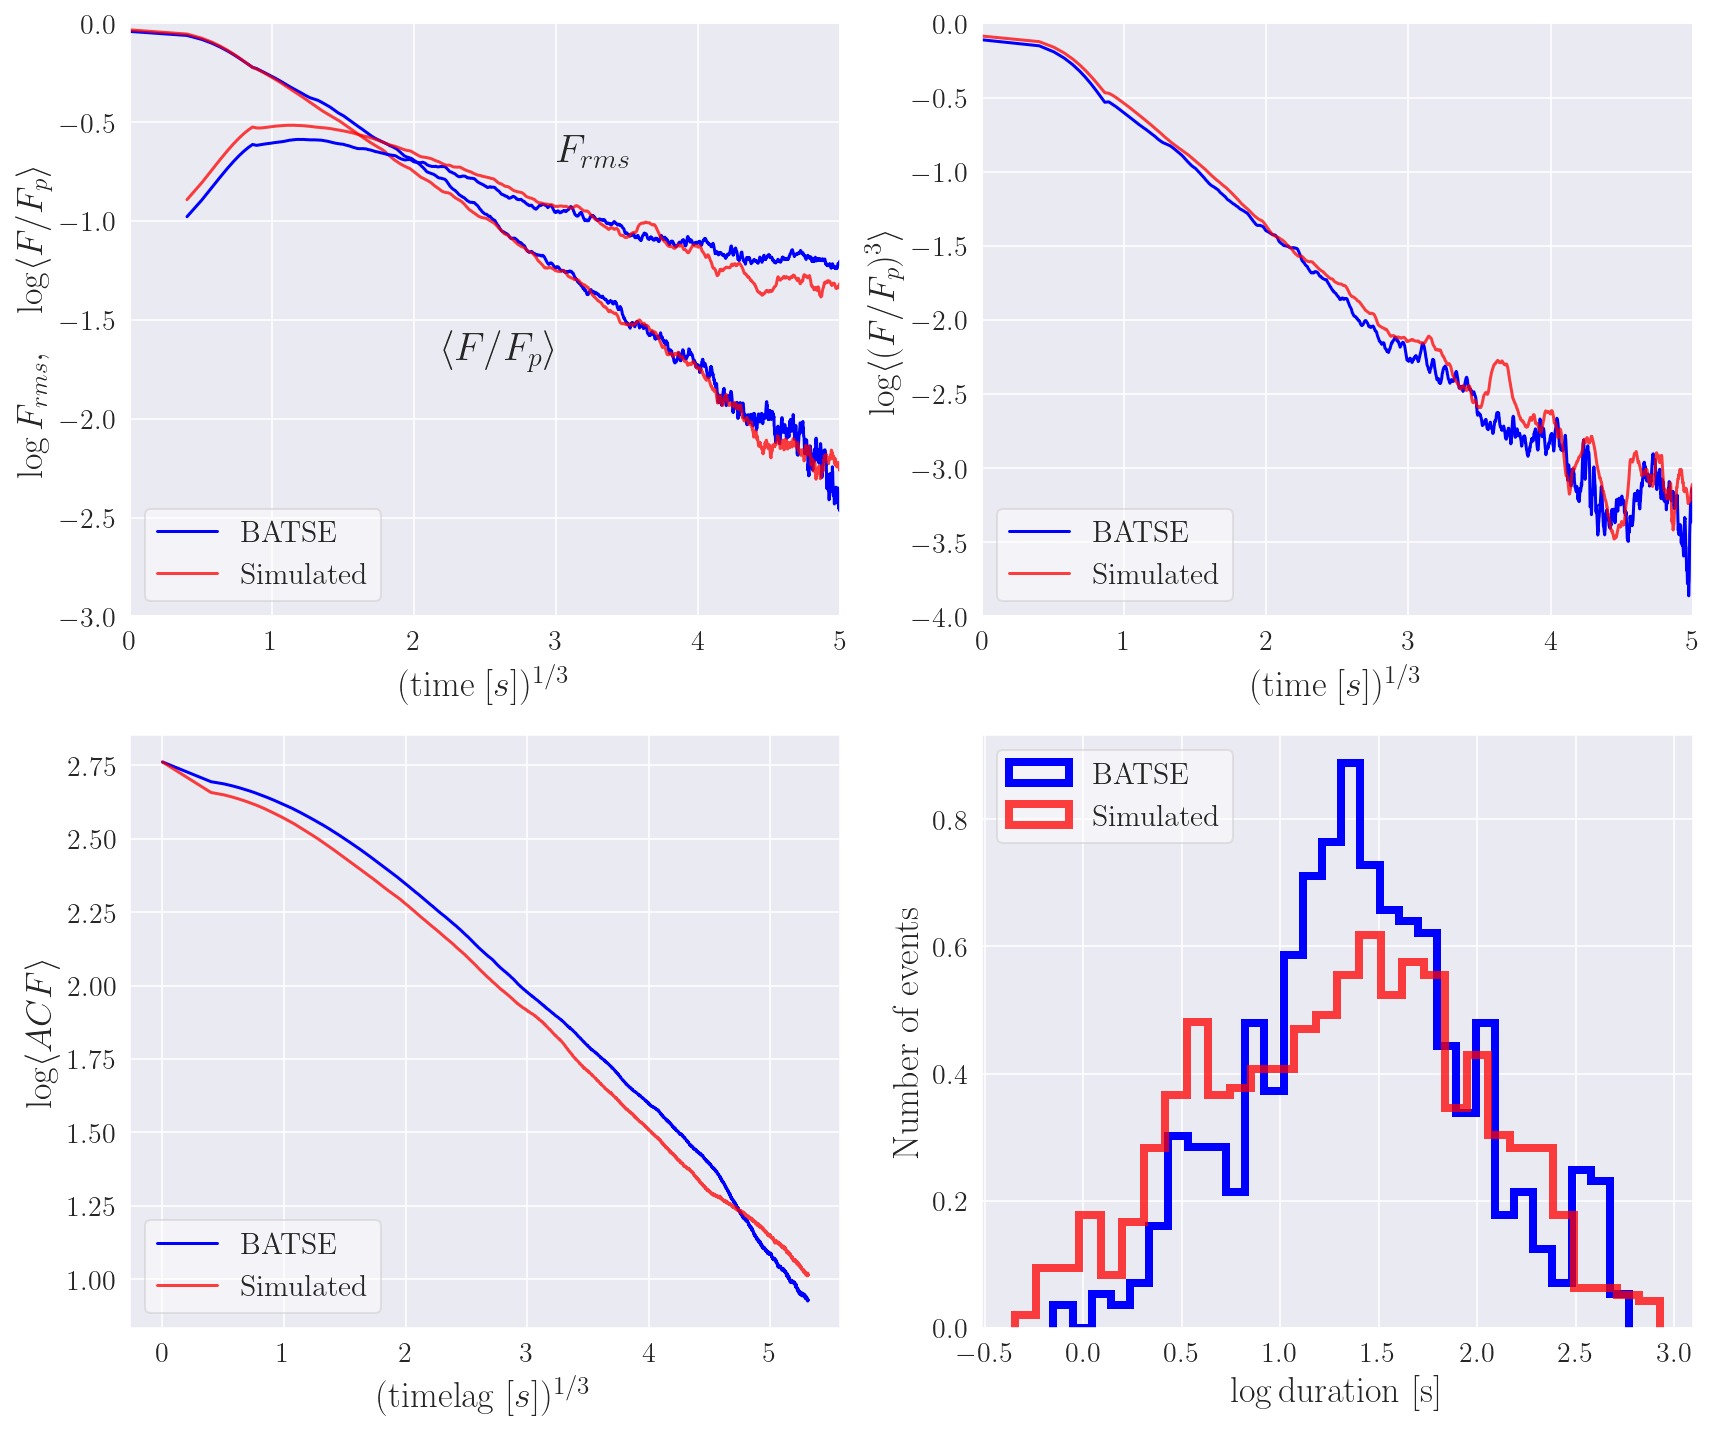

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(14,12))

#------------------------------------------------------------------------------#
# <(F/F_p)>
#------------------------------------------------------------------------------#

print('- plotting <(F/F_p)>...')
ax[0,0].set_axisbelow(True)
ax[0,0].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',                   size=18)
ax[0,0].set_ylabel(r'$\log F_{rms},\quad \log \langle F/F_p\rangle$', size=18)
#
ax[0,0].plot(test_times**(1/3),     np.log10(averaged_fluxes_batse),         color = 'b', alpha=1.00, label = r'BATSE')
ax[0,0].plot(test_times**(1/3),     np.log10(averaged_fluxes_sim),           color = 'r', alpha=0.75, label = r'Simulated')
ax[0,0].plot(test_times[1:]**(1/3), np.log10(averaged_fluxes_rms_batse[1:]), color = 'b', alpha=1.00)
ax[0,0].plot(test_times[1:]**(1/3), np.log10(averaged_fluxes_rms_sim[1:]),   color = 'r', alpha=0.75)
#
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(-3,0)
ax[0,0].text(3,   -0.7, r'$F_{rms}$',              fontsize=20)
ax[0,0].text(2.2, -1.7, r'$\langle F/F_p\rangle$', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=14)
ax[0,0].yaxis.set_tick_params(labelsize=14)
ax[0,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)
print('\tdone')

#------------------------------------------------------------------------------#
# <(F/F_p)^3>
#------------------------------------------------------------------------------#

print('- plotting <(F/F_p)^3>...')
ax[0,1].set_axisbelow(True)
ax[0,1].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',     size=18)
ax[0,1].set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$', size=18)
ax[0,1].plot(test_times**(1/3), np.log10(averaged_fluxes_cube_batse), color='b', label='BATSE')
ax[0,1].plot(test_times**(1/3), np.log10(averaged_fluxes_cube_sim),   color='r', label='Simulated', alpha=0.75)
ax[0,1].set_xlim(0,5)
ax[0,1].set_ylim(-4,0)
ax[0,1].xaxis.set_tick_params(labelsize=14)
ax[0,1].yaxis.set_tick_params(labelsize=14)
ax[0,1].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)
print('\tdone')

#------------------------------------------------------------------------------#
# AUTOCORRELATION
#------------------------------------------------------------------------------#

print('- plotting the autocorrelation...')
ax[1,0].plot((steps_batse*bin_time)**(1/3), np.log10(acf_batse), color='b', label='BATSE')
ax[1,0].plot((steps_sim  *bin_time)**(1/3), np.log10(acf_sim),   color='r', label='Simulated', alpha=0.75)
ax[1,0].set_xlabel(r'$(\mathrm{timelag}\ [s])^{1/3}$', size=18)
ax[1,0].set_ylabel(r'$\log \langle ACF \rangle$',      size=18)
#ax[1,0].set_xlim(0,5)
#ax[1,0].set_ylim(-2,0.2)
ax[1,0].xaxis.set_tick_params(labelsize=14)
ax[1,0].yaxis.set_tick_params(labelsize=14)
ax[1,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)
print('\tdone')

#------------------------------------------------------------------------------#
# HISTOGRAM OF DURATIONS
#------------------------------------------------------------------------------#

print('- plotting the histogram of the durations...')
ax[1,1].set_axisbelow(True)
ax[1,1].set_ylabel('Number of events', size=18)
ax[1,1].set_xlabel(r'$\log\mathrm{duration}$ [s]', size=18)

n_bins=30
n, bins, patches = ax[1,1].hist(x=np.log10(duration_batse),
                                bins=n_bins,
                                alpha=1.00,
                                label='BATSE', 
                                color='b',
                                histtype='step',
                                linewidth=4,
                                density=True)

n, bins, patches = ax[1,1].hist(x=np.log10(duration_sim),
                                bins=n_bins,
                                alpha=0.75,
                                label='Simulated', 
                                color='r',
                                histtype='step',
                                linewidth=4,
                                density=True)
                         
#ax[1,1].set_xlim(-2,3)
#ax[1,1].set_ylim(0,30)
ax[1,1].xaxis.set_tick_params(labelsize=14)
ax[1,1].yaxis.set_tick_params(labelsize=14)
ax[1,1].legend(prop={'size':15}, loc="upper left", facecolor='white', framealpha=0.5)
print('\tdone')

#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

plt.show()

# DEBUG

In [136]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_batse=np.log10(duration_batse)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
grid.fit(x_batse[:, None]) # Fit the histogram data
h_opt = grid.best_params_['bandwidth']
print('h_opt =', h_opt)

h_opt = 0.09081632653061224


(-0.5, 3.0)

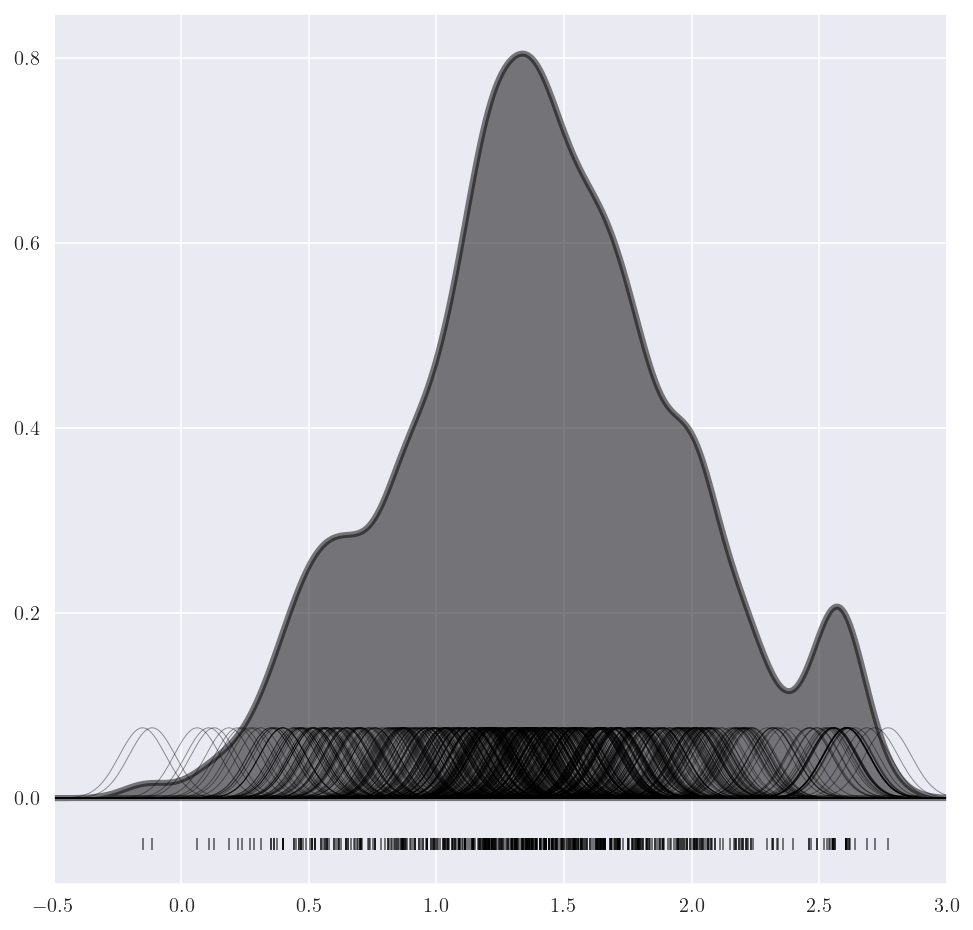

In [137]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot /= (len(x))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,3)

(-0.5, 3.0)

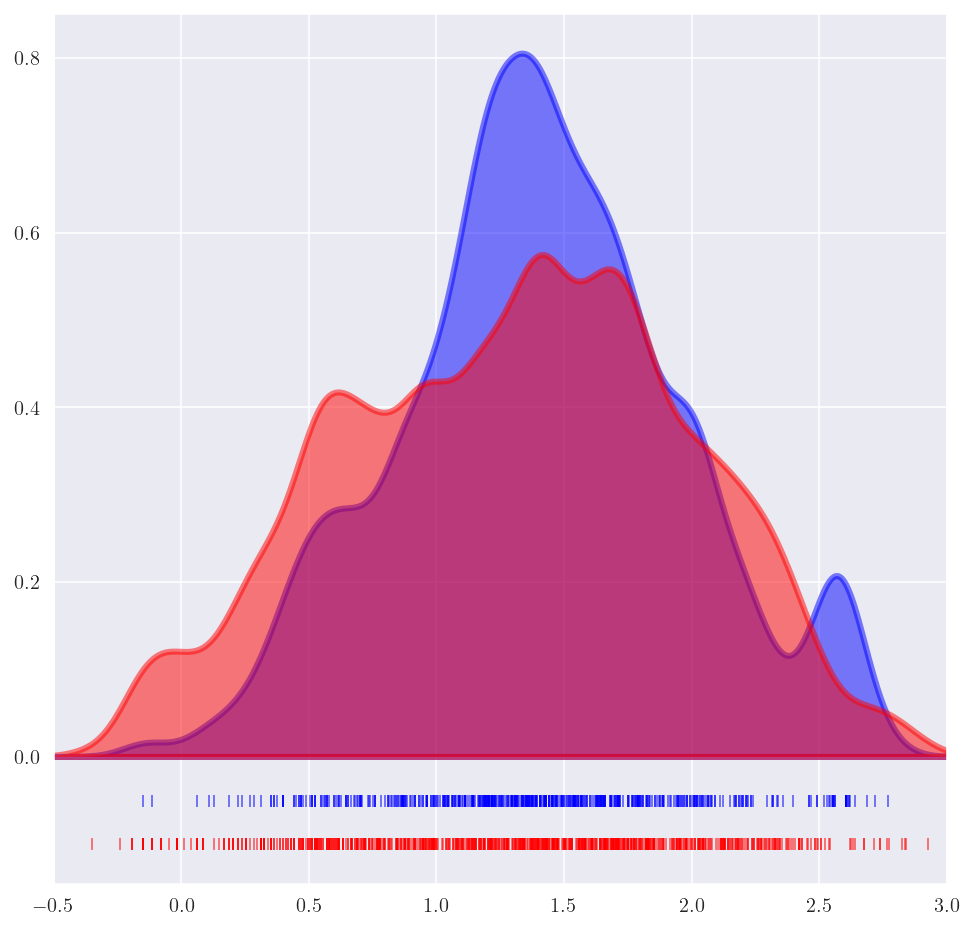

In [138]:

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_batse = np.log10(duration_batse)
x_sim   = np.log10(duration_sim)
#
x_grid        = np.linspace(-4, 4, 1000)
y_plot_batse  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot_sim    = stats.norm.pdf(x_grid, x_sim[:, None],   h_opt)
y_plot_batse /= (len(x_batse))
y_plot_sim   /= (len(x_sim))
#
ax.fill(x_grid, y_plot_batse.sum(0), ec='b', lw=3, fc='b', alpha=0.5)
ax.fill(x_grid, y_plot_sim.sum(0),   ec='r', lw=3, fc='r', alpha=0.5)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='b', alpha=0.5)
ax.plot(x_sim,   0*x_sim - 0.1,    '|', c='r', alpha=0.5)
ax.set_xlim(-0.5,3)

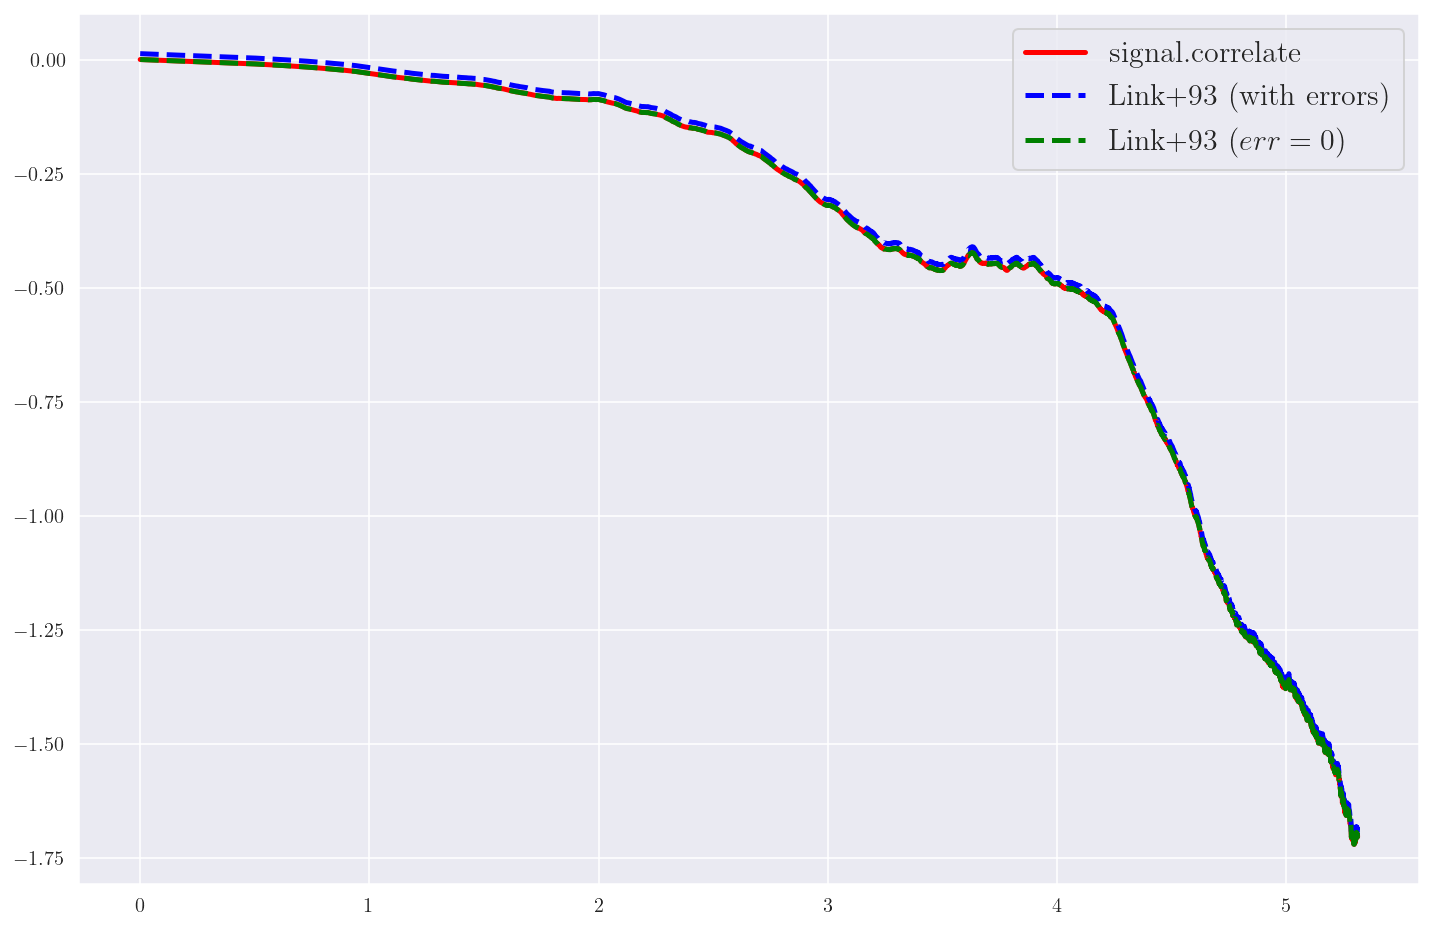

In [51]:
from scipy import signal

counts = grb_list_batse[0].counts
counts = np.float32(counts)
errs   = grb_list_batse[0].errs
steps  = int(t_f/bin_time)

corr   = signal.correlate(counts, counts)
lags   = signal.correlation_lags(len(counts), len(counts))
corr   = corr / np.max(corr)

t_min=0   # [s] min time lag for the autocorrelation
t_max=150 # [s] max time lag for the autocorrelation

idx_i = np.where(lags*bin_time==t_min)[0][0]
idx_f = np.where(lags*bin_time<=t_max)[0][-1]
assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
assert np.isclose(lags[idx_f]*bin_time, 150, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."

lags = lags[idx_i:idx_f+1]
corr = corr[idx_i:idx_f+1]

acf_link93_err = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(steps+1)]
acf_link93     = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2          ) for u in range(steps+1)]

plt.figure(figsize=(12,8))
plt.plot((lags2*bin_time)**(1/3.), np.log10(corr),           c='r', lw=2.5, ls='-',  label=r'signal.correlate')
plt.plot((lags2*bin_time)**(1/3.), np.log10(acf_link93_err), c='b', lw=2.5, ls='--', label=r'Link+93 (with errors)')
plt.plot((lags2*bin_time)**(1/3.), np.log10(acf_link93),     c='g', lw=2.5, ls='--', label=r'Link+93 ($err=0$)')
#plt.xlim(0,5)
plt.legend(prop={'size':15})
plt.show()

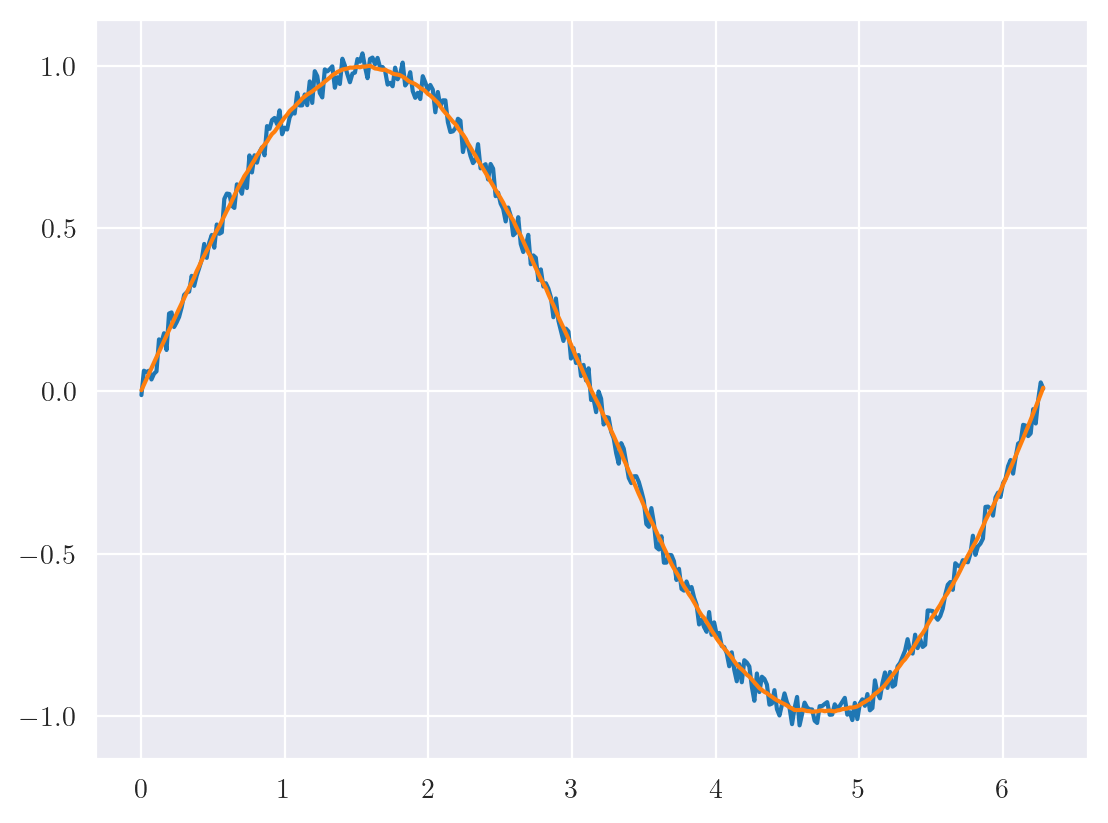

In [ ]:
#Savitzky-Golay filter test
from scipy.signal import savgol_filter

times = np.linspace(0,2*np.pi, 360)
vals = (np.sin(times) + (np.random.rand(len(times))-0.5)*0.1) 

filtered_vals = savgol_filter(vals, 41, 2,0)
plt.plot(times, vals)
plt.plot(times, filtered_vals)

NameError: name 'rebinFunction' is not defined

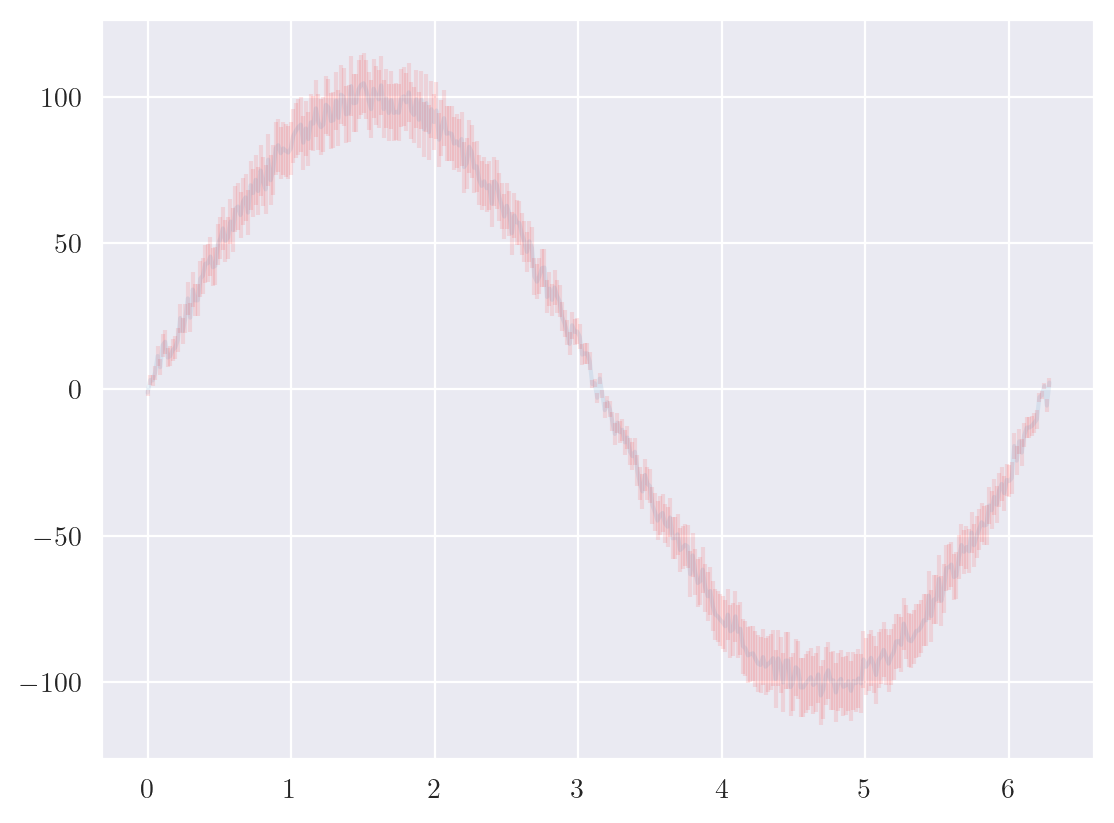

In [ ]:
#Rebin test

times = np.linspace(0,2*np.pi, 360)
vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
errs = np.sqrt(np.abs(vals))

plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
plt.plot(reb_time, reb_vals)

(100.0, 150.0)

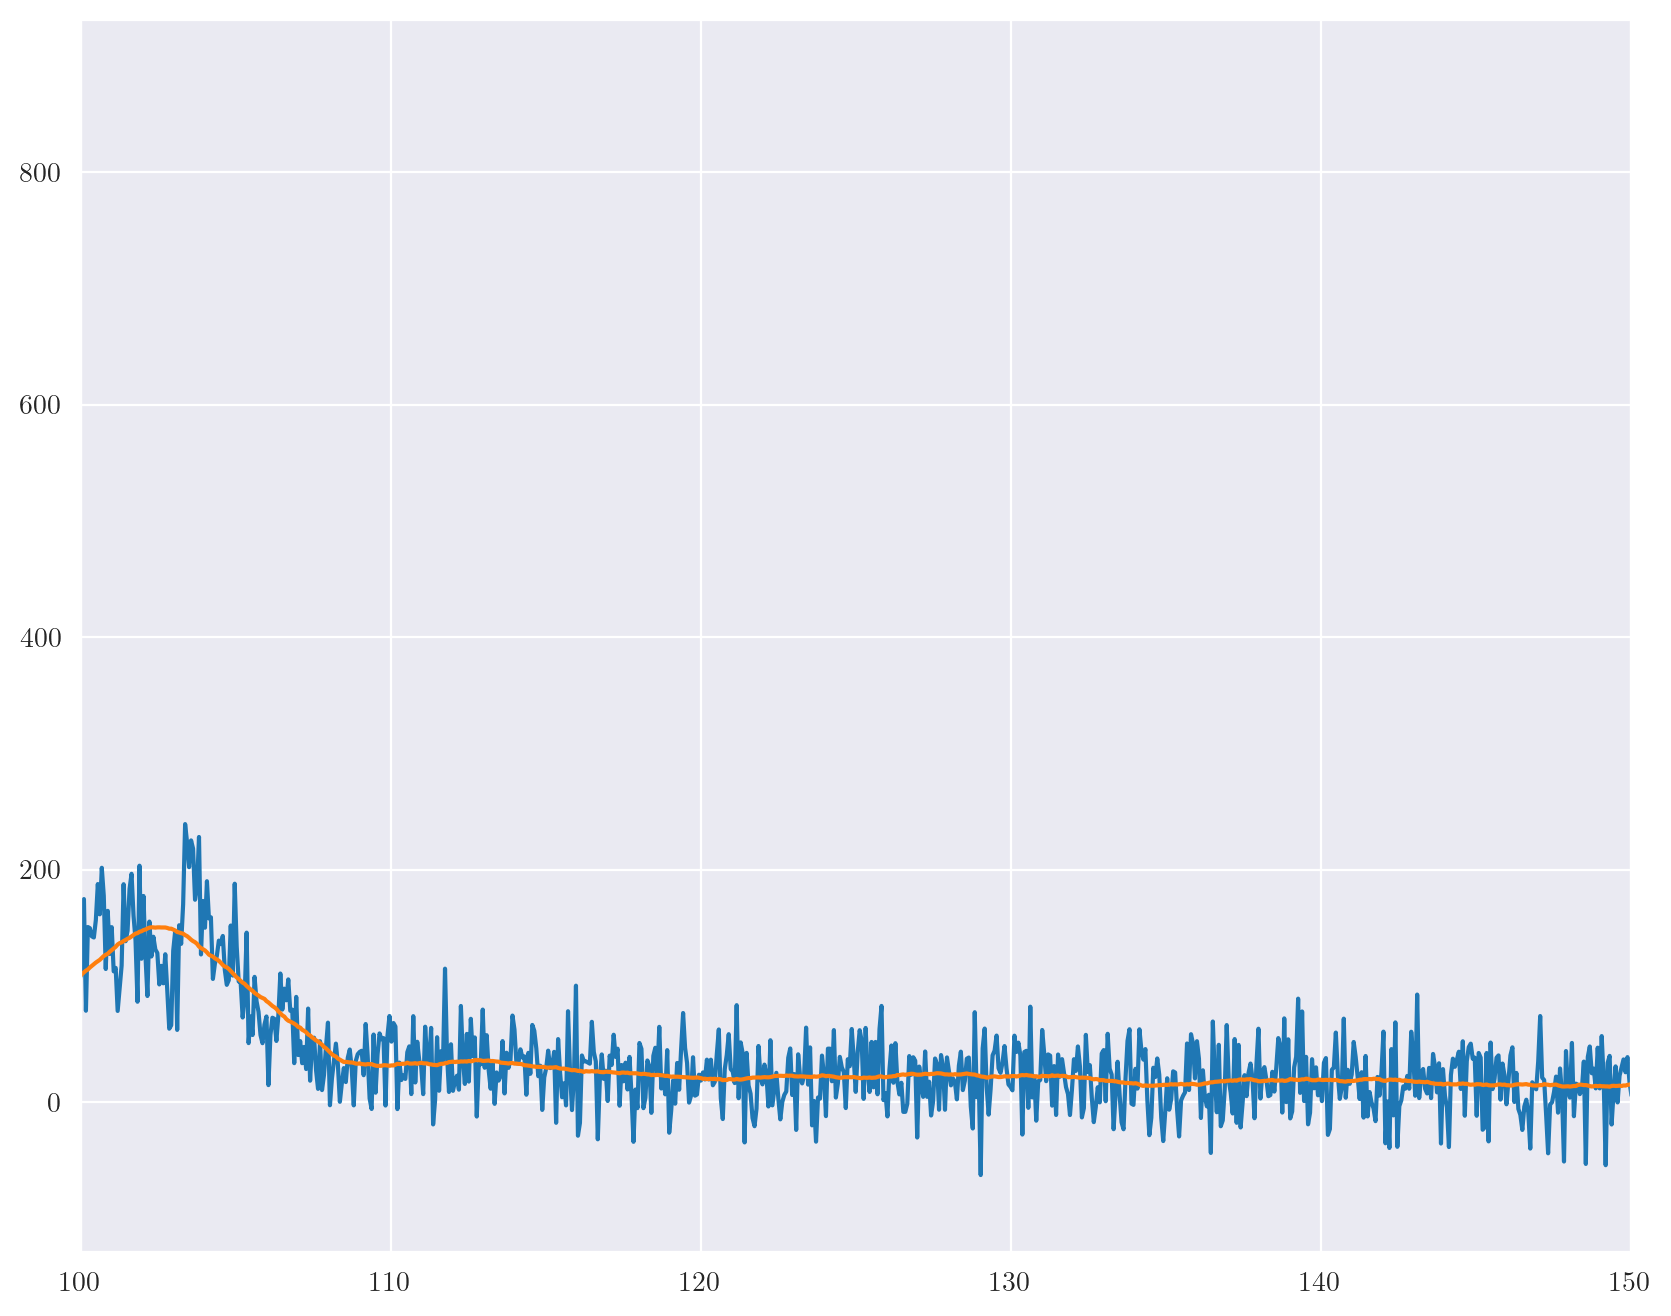

In [ ]:
times = grb_list_batse[0].times
vals = grb_list_batse[0].counts

filtered_vals = savgol_filter(vals, 161, 2 , 0)
plt.figure(figsize=(10,8))
plt.plot(times, vals)
plt.plot(times, filtered_vals)
plt.xlim(100,150)
#plt.xlim(-50,350)

In [ ]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93_test[1]
    if(acf_link93_test[1]<-50):
        print(acf_link93_test[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

NameError: name 'steps' is not defined

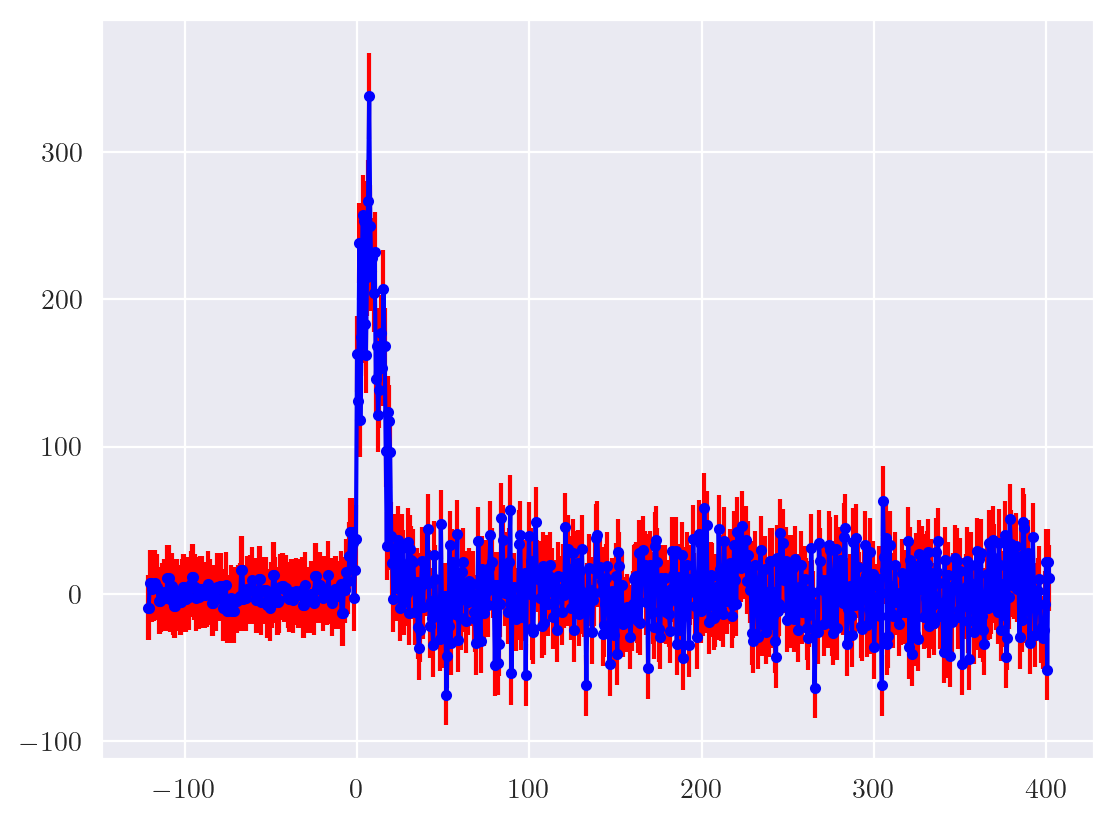

1.100963409212773 164


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

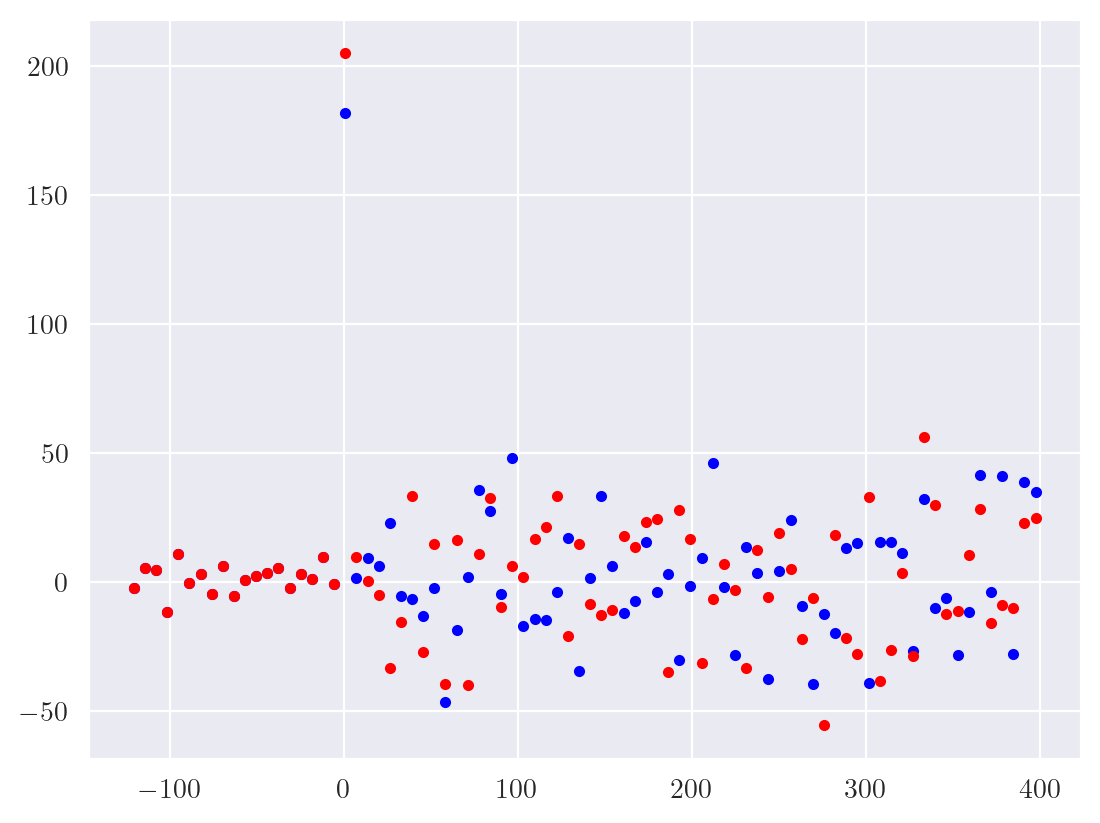

40.32327260478941 187


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

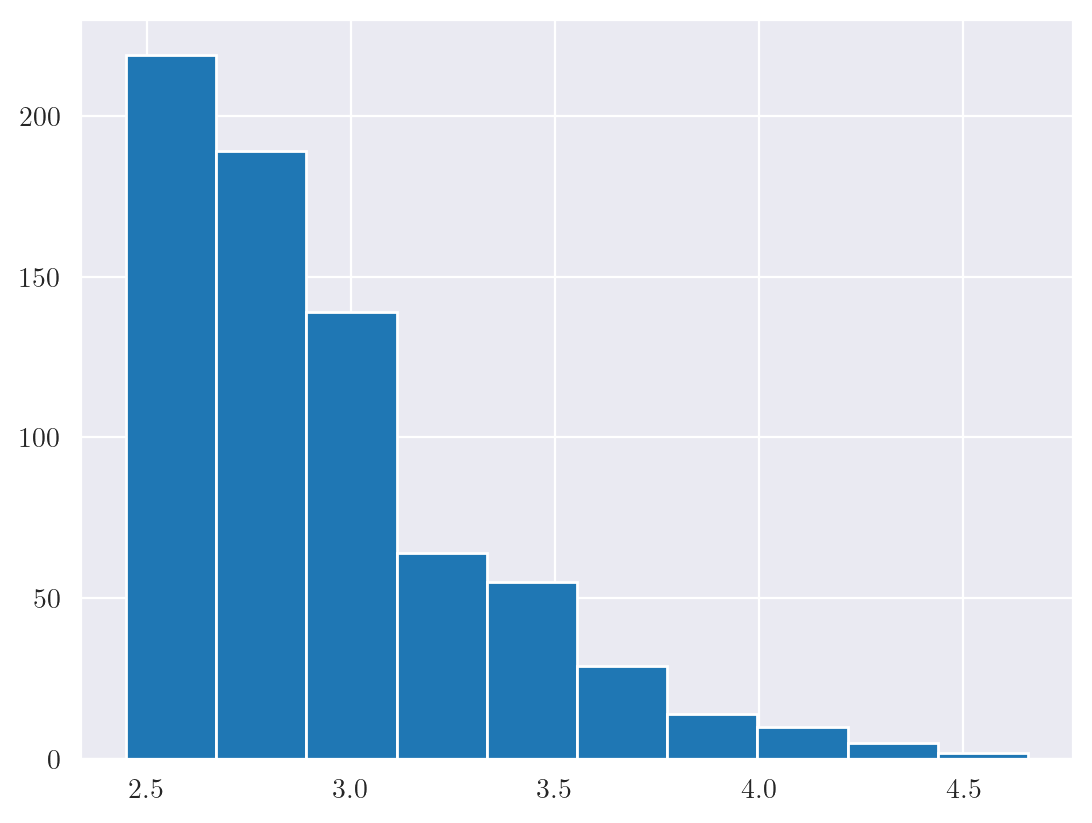

In [ ]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));